# Library

In [1]:
!pip install -q gdown

In [2]:
import requests
from zipfile import ZipFile
import gdown
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2

import tensorflow as tf
from tensorflow import keras
from tensorflow.python.keras import Sequential
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau
import tensorflow.keras.backend as K
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Activation, BatchNormalization, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate, Dropout, UpSampling2D, Layer, ReLU

from sklearn.preprocessing import StandardScaler, normalize
from sklearn.model_selection import train_test_split

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
tf.__version__, tf.config.list_physical_devices('GPU')

('2.12.0', [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')])

# Data

In [4]:
def get_file(url, target_path, extract_path):
    
    file_id = url.split('/')[-2]
    download_url = f'https://drive.google.com/uc?id={file_id}'
    gdown.download(download_url, target_path, quiet=False)

    with ZipFile(target_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
    os.remove(target_path)

In [5]:
url = 'https://drive.google.com/file/d/1n_RBnZWkd8_HSDySY7NWRbYwMQTk5cKJ/view?usp=drive_link'
target_path = '/kaggle/working/train_val'  
extract_path = '/kaggle/working/data'
get_file(url, target_path, extract_path)

url = 'https://drive.google.com/file/d/1qbsiQSZe-e4uKEo4FDbNJgvXqCW8OFm6/view?usp=drive_link'
target_path = '/kaggle/working/TEST'  
extract_path = '/kaggle/working/data'
get_file(url, target_path, extract_path)

Downloading...
From (original): https://drive.google.com/uc?id=1n_RBnZWkd8_HSDySY7NWRbYwMQTk5cKJ
From (redirected): https://drive.google.com/uc?id=1n_RBnZWkd8_HSDySY7NWRbYwMQTk5cKJ&confirm=t&uuid=2093e4b8-c165-470b-a45e-e62c8b5f44a5
To: /kaggle/working/train_val
100%|██████████| 172M/172M [00:02<00:00, 61.4MB/s] 
Downloading...
From: https://drive.google.com/uc?id=1qbsiQSZe-e4uKEo4FDbNJgvXqCW8OFm6
To: /kaggle/working/TEST
100%|██████████| 12.8M/12.8M [00:00<00:00, 123MB/s]


In [6]:
def dir_list(images_dir, masks_dir):
    
    images_names = sorted(os.listdir(images_dir))
    masks_names = sorted(os.listdir(masks_dir))
    
    image_list = []
    for name in images_names:
        image_list.append(os.path.join(images_dir, name))

    mask_list = []
    for name in masks_names:
        if name.endswith('.bmp'):
            mask_list.append(os.path.join(masks_dir, name))
    
    df = pd.DataFrame({'images':image_list,
                                'masks':mask_list})
        
    return df

In [7]:
train_mask = '/kaggle/working/data/train_val/masks'
train_image = '/kaggle/working/data/train_val/images'

train_val_df = dir_list(train_image, train_mask)

val_df=train_val_df.sample(frac=0.1,random_state=158)
train_df=train_val_df.drop(val_df.index)
val_df = val_df.reset_index(drop=True)
train_df = train_df.reset_index(drop=True)

In [8]:
test_mask = '/kaggle/working/data/TEST/masks'
test_image = '/kaggle/working/data/TEST/images'

test_df = dir_list(test_image, test_mask)

In [9]:
print(len(train_df))
train_df.head()

1373


images  \
0  /kaggle/working/data/train_val/images/d_r_103_...   
1  /kaggle/working/data/train_val/images/d_r_105_...   
2  /kaggle/working/data/train_val/images/d_r_112_...   
3  /kaggle/working/data/train_val/images/d_r_113_...   
4  /kaggle/working/data/train_val/images/d_r_125_...   

                                               masks  
0  /kaggle/working/data/train_val/masks/d_r_103_.bmp  
1  /kaggle/working/data/train_val/masks/d_r_105_.bmp  
2  /kaggle/working/data/train_val/masks/d_r_112_.bmp  
3  /kaggle/working/data/train_val/masks/d_r_113_.bmp  
4  /kaggle/working/data/train_val/masks/d_r_125_.bmp

In [10]:
print(len(val_df))
val_df.head()

152


images  \
0  /kaggle/working/data/train_val/images/f_r_1875...   
1  /kaggle/working/data/train_val/images/w_r_64_.jpg   
2  /kaggle/working/data/train_val/images/f_r_2011...   
3  /kaggle/working/data/train_val/images/f_r_319_...   
4  /kaggle/working/data/train_val/images/f_r_2041...   

                                               masks  
0  /kaggle/working/data/train_val/masks/f_r_1875_...  
1   /kaggle/working/data/train_val/masks/w_r_64_.bmp  
2  /kaggle/working/data/train_val/masks/f_r_2011_...  
3  /kaggle/working/data/train_val/masks/f_r_319_.bmp  
4  /kaggle/working/data/train_val/masks/f_r_2041_...

In [11]:
print(len(test_df))
test_df.head()

110


images  \
0  /kaggle/working/data/TEST/images/d_r_122_.jpg   
1  /kaggle/working/data/TEST/images/d_r_129_.jpg   
2  /kaggle/working/data/TEST/images/d_r_144_.jpg   
3  /kaggle/working/data/TEST/images/d_r_166_.jpg   
4  /kaggle/working/data/TEST/images/d_r_182_.jpg   

                                          masks  
0  /kaggle/working/data/TEST/masks/d_r_122_.bmp  
1  /kaggle/working/data/TEST/masks/d_r_129_.bmp  
2  /kaggle/working/data/TEST/masks/d_r_144_.bmp  
3  /kaggle/working/data/TEST/masks/d_r_166_.bmp  
4  /kaggle/working/data/TEST/masks/d_r_182_.bmp

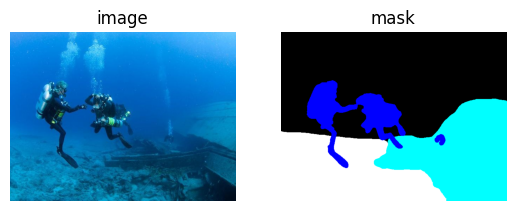

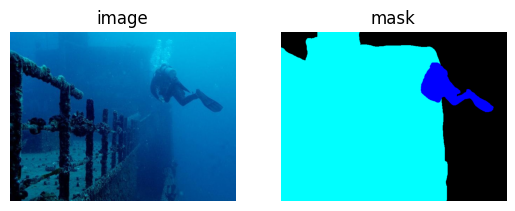

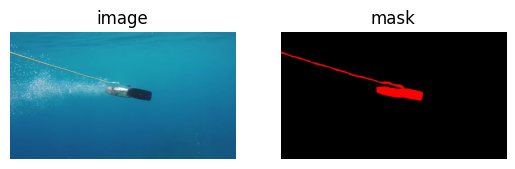

In [12]:
for i in range(3):
    plt.subplot(1,2,1)
    plt.imshow(plt.imread(train_df['images'][i]))
    plt.axis('off')
    plt.title('image')
    
    plt.subplot(1,2,2)
    plt.imshow(plt.imread(train_df['masks'][i]))
    plt.title('mask')
    plt.axis('off')

    plt.show()

In [13]:
def dir_list_allmask(test_df, test_mask):
    
    test_mask_list = os.listdir(test_mask)
    class_mask = []
    for name in test_mask_list:
        if not name.endswith('.bmp'):
            class_mask.append(name)
    
    for mask_dir_name in class_mask:
        
        masks_dir = test_mask + '/' + mask_dir_name
        masks_names = sorted(os.listdir(masks_dir))

        mask_list = []
        for name in masks_names:
            if name.endswith('.bmp'):
                mask_list.append(os.path.join(masks_dir, name))

        test_df[mask_dir_name] = mask_list
        
    return test_df

In [14]:
test_mask = '/kaggle/working/data/TEST/masks'
test_df_allmask = dir_list_allmask(test_df, test_mask)
test_df_allmask.head()

images  \
0  /kaggle/working/data/TEST/images/d_r_122_.jpg   
1  /kaggle/working/data/TEST/images/d_r_129_.jpg   
2  /kaggle/working/data/TEST/images/d_r_144_.jpg   
3  /kaggle/working/data/TEST/images/d_r_166_.jpg   
4  /kaggle/working/data/TEST/images/d_r_182_.jpg   

                                          masks  \
0  /kaggle/working/data/TEST/masks/d_r_122_.bmp   
1  /kaggle/working/data/TEST/masks/d_r_129_.bmp   
2  /kaggle/working/data/TEST/masks/d_r_144_.bmp   
3  /kaggle/working/data/TEST/masks/d_r_166_.bmp   
4  /kaggle/working/data/TEST/masks/d_r_182_.bmp   

                                                RI  \
0  /kaggle/working/data/TEST/masks/RI/d_r_122_.bmp   
1  /kaggle/working/data/TEST/masks/RI/d_r_129_.bmp   
2  /kaggle/working/data/TEST/masks/RI/d_r_144_.bmp   
3  /kaggle/working/data/TEST/masks/RI/d_r_166_.bmp   
4  /kaggle/working/data/TEST/masks/RI/d_r_182_.bmp   

                                                SR  \
0  /kaggle/working/data/TEST/masks/SR/d_r_122_.bmp   
1  /kaggle/working/data/TEST/masks/SR/d_r_129_.bmp   
2  /kaggle/working/data/TEST/masks/SR/d_r_144_.bmp   
3  /kaggle/working/data/TEST/masks/SR/d_r_166_.bmp   
4  /kaggle/working/data/TEST/masks/SR/d_r_182_.bmp   

                                            Saliency  \
0  /kaggle/working/data/TEST/masks/Saliency/d_r_1...   
1  /kaggle/working/data/TEST/masks/Saliency/d_r_1...   
2  /kaggle/working/data/TEST/masks/Saliency/d_r_1...   
3  /kaggle/working/data/TEST/masks/Saliency/d_r_1...   
4  /kaggle/working/data/TEST/masks/Saliency/d_r_1...   

                                                RO  \
0  /kaggle/working/data/TEST/masks/RO/d_r_122_.bmp   
1  /kaggle/working/data/TEST/masks/RO/d_r_129_.bmp   
2  /kaggle/working/data/TEST/masks/RO/d_r_144_.bmp   
3  /kaggle/working/data/TEST/masks/RO/d_r_166_.bmp   
4  /kaggle/working/data/TEST/masks/RO/d_r_182_.bmp   

                                                FV  \
0  /kaggle/working/data/TEST/masks/FV/d_r_122_.bmp   
1  /kaggle/working/data/TEST/masks/FV/d_r_129_.bmp   
2  /kaggle/working/data/TEST/masks/FV/d_r_144_.bmp   
3  /kaggle/working/data/TEST/masks/FV/d_r_166_.bmp   
4  /kaggle/working/data/TEST/masks/FV/d_r_182_.bmp   

                                                WR  \
0  /kaggle/working/data/TEST/masks/WR/d_r_122_.bmp   
1  /kaggle/working/data/TEST/masks/WR/d_r_129_.bmp   
2  /kaggle/working/data/TEST/masks/WR/d_r_144_.bmp   
3  /kaggle/working/data/TEST/masks/WR/d_r_166_.bmp   
4  /kaggle/working/data/TEST/masks/WR/d_r_182_.bmp   

                                                PF  \
0  /kaggle/working/data/TEST/masks/PF/d_r_122_.bmp   
1  /kaggle/working/data/TEST/masks/PF/d_r_129_.bmp   
2  /kaggle/working/data/TEST/masks/PF/d_r_144_.bmp   
3  /kaggle/working/data/TEST/masks/PF/d_r_166_.bmp   
4  /kaggle/working/data/TEST/masks/PF/d_r_182_.bmp   

                                                HD  
0  /kaggle/working/data/TEST/masks/HD/d_r_122_.bmp  
1  /kaggle/working/data/TEST/masks/HD/d_r_129_.bmp  
2  /kaggle/working/data/TEST/masks/HD/d_r_144_.bmp  
3  /kaggle/working/data/TEST/masks/HD/d_r_166_.bmp  
4  /kaggle/working/data/TEST/masks/HD/d_r_182_.bmp

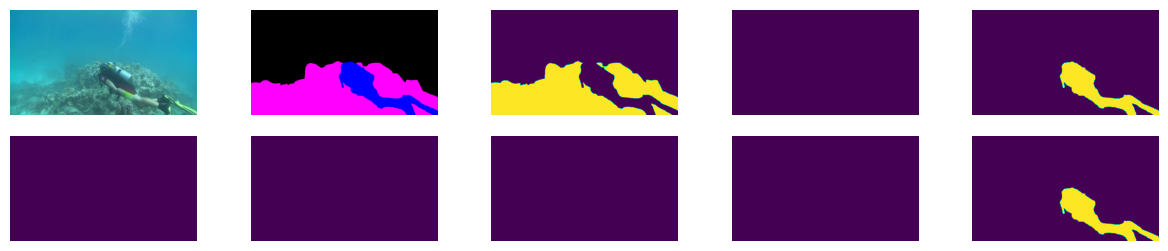

In [15]:
idx = 15
plt.figure(figsize=(15, 3))

for i, dir_ in enumerate(test_df_allmask.iloc[idx]):
    plt.subplot(2,5,i+1)
    plt.imshow(plt.imread(dir_))
    plt.axis('off')
    
plt.show()

# Data Augmetation

In [105]:
def train_generator(data_frame, batch_size, target_size=(128,128), train = True, seed=1):
    
    if train:
        
        image_datagen = ImageDataGenerator(rotation_range=0.2, width_shift_range=0.05, height_shift_range=0.05, shear_range=0.05,
                                            zoom_range=0.05, horizontal_flip=True, fill_mode='nearest')

        mask_datagen = ImageDataGenerator(rotation_range=0.2, width_shift_range=0.05, height_shift_range=0.05, shear_range=0.05,
                                          zoom_range=0.05, horizontal_flip=True, fill_mode='nearest')
        
    else:
        image_datagen = ImageDataGenerator()

        mask_datagen = ImageDataGenerator()
                                       
    image_generator = image_datagen.flow_from_dataframe(
        data_frame,
        x_col = "images",
        color_mode = 'rgb',
        class_mode = None,
        target_size = target_size,
        batch_size = batch_size,
        seed = seed)

    mask_generator = mask_datagen.flow_from_dataframe(
        data_frame,
        x_col = "masks",
        color_mode = 'grayscale',
        class_mode = None,
        target_size = target_size,
        batch_size = batch_size,
        seed = seed)
                                       
                                                                  
    train_gen = zip(image_generator, mask_generator)
    
    for (img, mask) in train_gen:
        img = img/255.
        mask = mask/255.
        mask[mask>=0.1]= 1,
        mask[mask<0.1]= 0,

        yield (img, mask)

In [58]:
BATCH_SIZE = 4
im_height = 320
im_width = 240

train_gen = train_generator(train_df, BATCH_SIZE, target_size=(im_height,im_width), train = True, seed=1)
valid_gen = train_generator(val_df, BATCH_SIZE, target_size=(im_height,im_width), train = False, seed=1)
test_gen = train_generator(test_df, BATCH_SIZE, target_size=(im_height,im_width), train = False, seed=1)

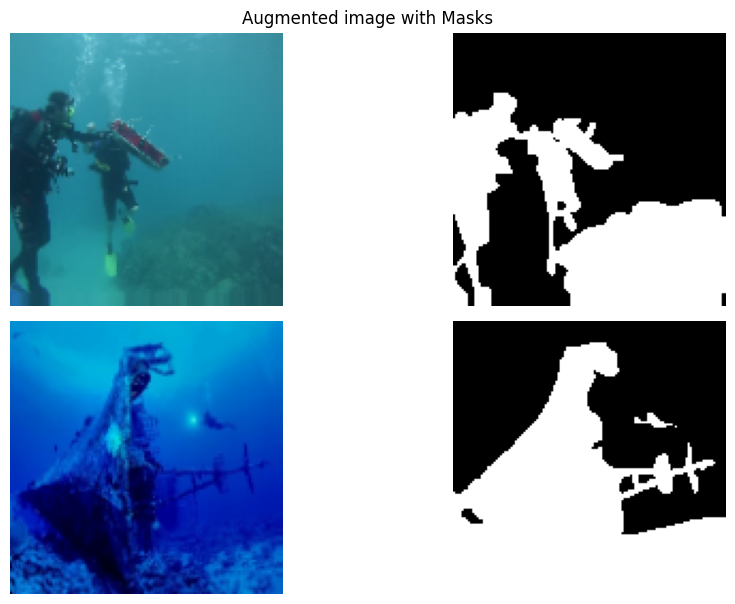

In [193]:
for (img, mask) in train_gen:
    break

idx = [0, 2]

plt.figure(figsize=(9, 12))
plt.suptitle('Augmented image with Masks')
for i in idx:
    
    plt.subplot(4, 2, i+1)
    image = (img[i]*255).astype(np.uint8)
    plt.imshow(image)
    plt.axis('off')
    
    plt.subplot(4, 2, i+2)
    plt.imshow(mask[i], cmap='gray')
    plt.axis('off')

plt.tight_layout()
plt.show()

# UNet

**Network**
===

In [16]:
def conv_down(inputs, num_filter, attention=False):
    
    conv1 = Conv2D(num_filter, (3, 3), padding='same', activation='relu')(inputs)
    bn1 = BatchNormalization()(conv1)
    conv2 = Conv2D(num_filter, (3, 3), padding='same', activation='relu')(bn1)
    bn2 = BatchNormalization()(conv2)                            
    drp = Dropout(0.1)(bn2)
    
    if attention:
        drp = TripletAttention()(drp)
        
    pool = MaxPooling2D(pool_size=(2, 2))(drp)
    return conv2, pool, drp

def conv_up(input1, input2, num_filter1, num_filter2):
    
    up1 = UpSampling2D()(input1)
    up1 = Conv2D(num_filter1, (1, 1), padding='same', activation='relu')(up1)
    up2 = concatenate([up1, input2], axis=3)
    conv1 = Conv2D(num_filter2, (3, 3), padding='same', activation='relu')(up2)
    bn1 = BatchNormalization()(conv1)
    conv2 = Conv2D(num_filter2, (3, 3), padding='same', activation='relu')(bn1)
    bn2 = BatchNormalization()(conv2)                            
    drp = Dropout(0.1)(bn2)
    return drp

In [22]:
def UNet(input_size=(im_height,im_width,3)):
    
    inputs = Input(input_size)
    
    conv1, pool1, drp1 = conv_down(inputs, 64)
    conv2, pool2, drp2 = conv_down(pool1, 128)    
    conv3, pool3, drp3 = conv_down(pool2, 256)    
    conv4, pool4, drp4 = conv_down(pool3, 512)    
    _, _ , drp5 = conv_down(pool4, 1024)   
    
    drp6 = conv_up(drp5, drp4, 512, 512)
    drp7 = conv_up(drp6, drp3, 256, 256)    
    drp8 = conv_up(drp7, drp2, 128, 64)    
    drp9 = conv_up(drp8, drp1, 64, 64)
    
    out = Conv2D(1, (1, 1), activation='sigmoid')(drp9)
    
    return Model(inputs=[inputs], outputs=[out])

In [196]:
im_height = 320
im_width = 240
model = UNet(input_size=(im_height,im_width,3))
model.summary()

Model: "model_29"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_45 (InputLayer)          [(None, 320, 240, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_1026 (Conv2D)           (None, 320, 240, 64  1792        ['input_45[0][0]']               
                                )                                                                 
                                                                                                  
 batch_normalization_571 (Batch  (None, 320, 240, 64  256        ['conv2d_1026[0][0]']            
 Normalization)                 )                                                          

**Train**
===

In [23]:
from tensorflow.keras.losses import binary_crossentropy

def iou_coef(y_true, y_pred, smooth=100):
    intersection = K.sum(y_true * y_pred)
    union = K.sum(y_true) +  K.sum(y_pred)
    iou = (intersection)/(union - intersection + smooth)
    return iou

def lovasz_loss(y_true, y_pred, smooth=100):
    return 1-iou_coef(y_true, y_pred, smooth)

def combined_loss(y_true, y_pred, smooth=100, bce_weight=0.7, lovasz_weight=0.3):
    bce_loss = binary_crossentropy(y_true, y_pred)
    lovasz = lovasz_loss(y_true, y_pred, smooth)
    return bce_weight * bce_loss + lovasz_weight * lovasz

In [198]:
BATCH_SIZE = 32
im_height = 128
im_width = 128

train_gen = train_generator(train_df, BATCH_SIZE, target_size=(im_height,im_width), train = True, seed=1)
valid_gen = train_generator(val_df, BATCH_SIZE, target_size=(im_height,im_width), train = False, seed=1)
test_gen = train_generator(test_df, BATCH_SIZE, target_size=(im_height,im_width), train = False, seed=1)

In [199]:
EPOCHS = 50
n_classes = 2
BATCH_SIZE = 32
im_height = 128
im_width = 128

mean_iou = keras.metrics.MeanIoU(num_classes=num_class, name="mean_iou")
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001)

unet_model = UNet(input_size=(im_height, im_width, 3))
unet_model.compile(optimizer=optimizer, loss= 'binary_crossentropy', metrics=["binary_accuracy", mean_iou, iou_coef])

unet_model_history = unet_model.fit(train_gen,
                    steps_per_epoch = len(train_df) / BATCH_SIZE, 
                    epochs=EPOCHS, 
                    validation_data = valid_gen,
                    validation_steps = len(val_df) / BATCH_SIZE)
                    #callbacks = callbacks)

Found 1373 validated image filenames.
Found 1373 validated image filenames.
Epoch 1/50


2024-06-26 20:53:54.685701: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_30/dropout_194/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


43/42 [==============================] - ETA: 0s - loss: 0.4906 - binary_accuracy: 0.7893 - mean_iou: 0.1534 - iou_coef: 0.6217Found 152 validated image filenames.
Found 152 validated image filenames.
42/42 [==============================] - 28s 321ms/step - loss: 0.4906 - binary_accuracy: 0.7893 - mean_iou: 0.1534 - iou_coef: 0.6217 - val_loss: 0.6214 - val_binary_accuracy: 0.8103 - val_mean_iou: 0.1544 - val_iou_coef: 0.5037
Epoch 2/50
42/42 [==============================] - 13s 311ms/step - loss: 0.3646 - binary_accuracy: 0.8662 - mean_iou: 0.1533 - iou_coef: 0.7177 - val_loss: 0.7786 - val_binary_accuracy: 0.5336 - val_mean_iou: 0.1549 - val_iou_coef: 0.3936
Epoch 3/50
42/42 [==============================] - 13s 306ms/step - loss: 0.3541 - binary_accuracy: 0.8679 - mean_iou: 0.1532 - iou_coef: 0.7255 - val_loss: 0.7424 - val_binary_accuracy: 0.7609 - val_mean_iou: 0.1560 - val_iou_coef: 0.5998
Epoch 4/50
42/42 [==============================] - 13s 309ms/step - loss: 0.3274 - bin

**Result**
===

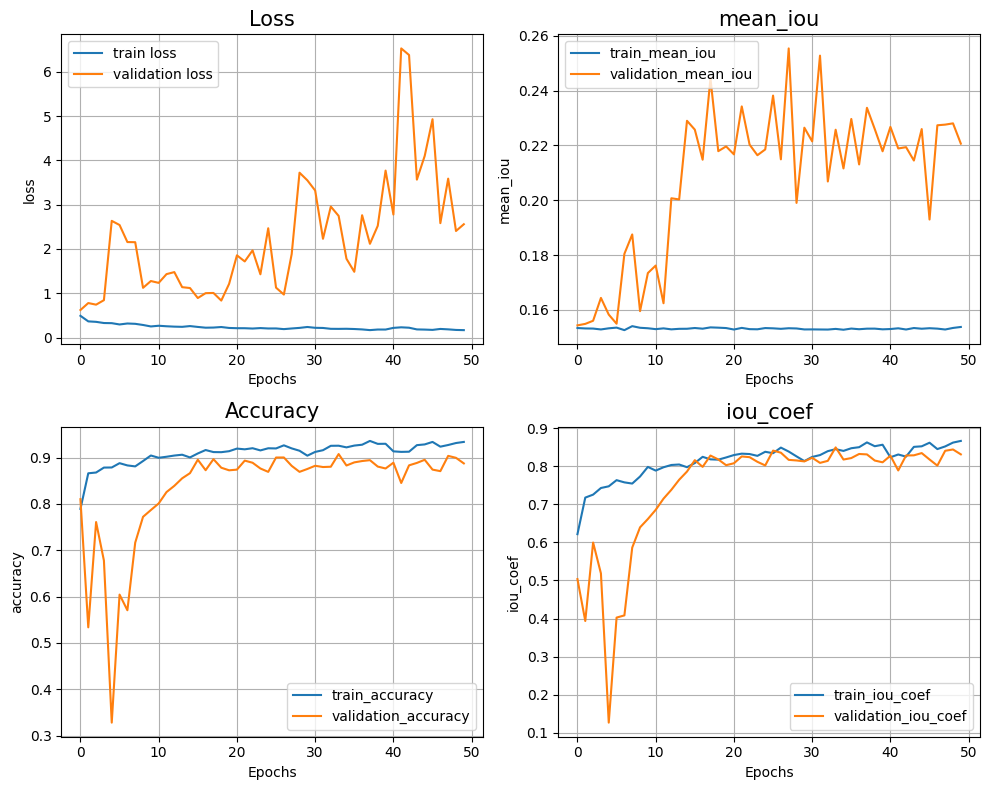

In [200]:
histori = unet_model_history.history
plt.figure(figsize=(10,8))

plt.subplot(2,2,1)
train_loss = histori['loss']
val_loss = histori['val_loss']
plt.plot(train_loss, label='train loss')
plt.plot(val_loss, label='validation loss')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.title('Loss', fontsize = 15)
plt.legend()
plt.grid()

plt.subplot(2,2,2)
train_dice = histori['mean_iou']
val_dice = histori['val_mean_iou']
plt.plot(train_dice, label= 'train_mean_iou')
plt.plot(val_dice, label= 'validation_mean_iou')
plt.xlabel('Epochs')
plt.ylabel('mean_iou')
plt.title('mean_iou', fontsize = 15)
plt.legend()
plt.grid()


plt.subplot(2,2,3)
train_acc = histori['binary_accuracy']
val_acc = histori['val_binary_accuracy']
plt.plot(train_acc, label= 'train_accuracy')
plt.plot(val_acc, label= 'validation_accuracy')
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.legend()
plt.title('Accuracy', fontsize = 15)
plt.grid()

plt.subplot(2,2,4)
train_acc = histori['iou_coef']
val_acc = histori['val_iou_coef']
plt.plot(train_acc, label= 'train_iou_coef')
plt.plot(val_acc, label= 'validation_iou_coef')
plt.xlabel('Epochs')
plt.ylabel('iou_coef')
plt.title('iou_coef', fontsize = 15)
plt.grid()

plt.tight_layout()
plt.legend()
plt.show()

In [201]:
results = unet_model.evaluate(test_gen, 
                         steps=len(test_df) / BATCH_SIZE)

print(f"Test loss: {results[0]:0.2f}")
print(f"Test acc: {results[1]*100:0.2f}%")
print(f"Test mean IOU: {results[2]:0.2f}")
print(f"Test IOU coef: {results[3]:0.2f}")

Found 110 validated image filenames.
Found 110 validated image filenames.
3/3 [==============================] - 0s 132ms/step - loss: 0.3133 - binary_accuracy: 0.9104 - mean_iou: 0.2100 - iou_coef: 0.8078
Test loss: 0.31
Test acc: 91.04%
Test mean IOU: 0.21
Test IOU coef: 0.81


1/1 [==============================] - 0s 390ms/step


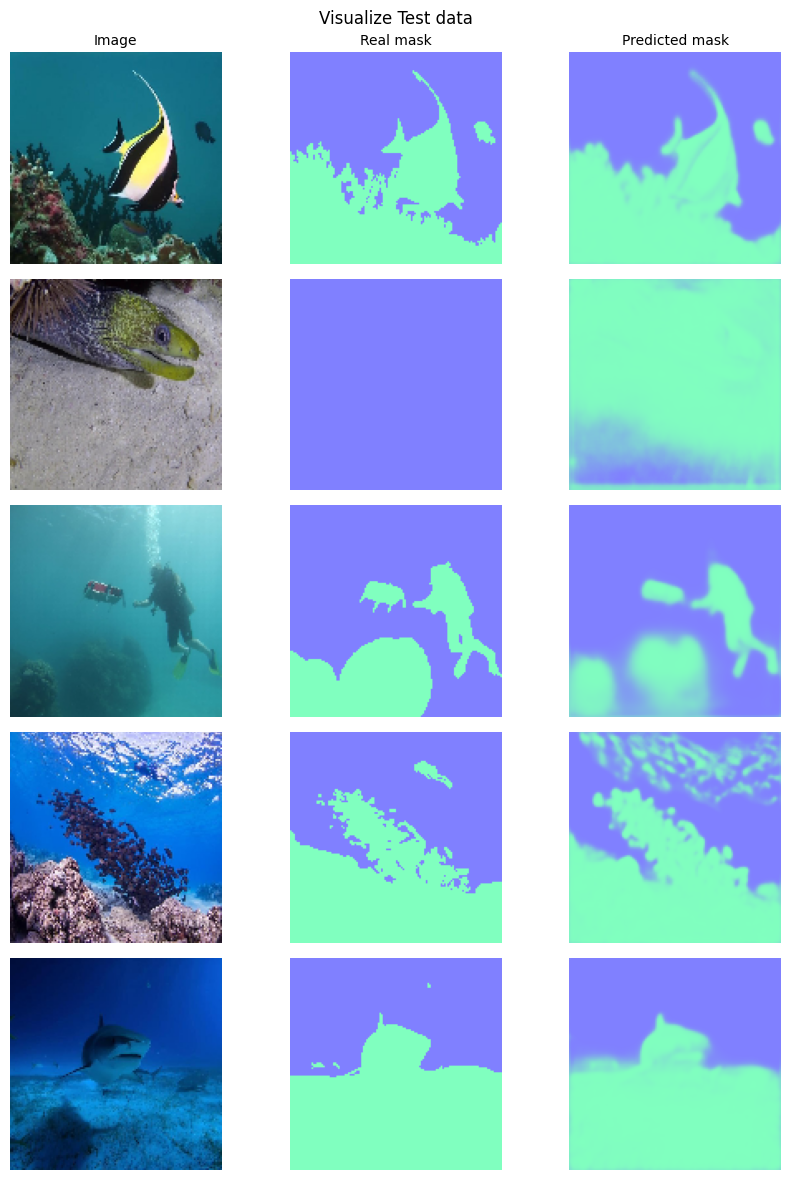

In [202]:
for img, mask in test_gen:
    break
pred = unet_model.predict(img)

fig, ax = plt.subplots(nrows=5, ncols=3, figsize=(9,12))
plt.suptitle('Visualize Test data', fontsize = 12)
ax = ax.ravel()

for k, i in zip(range(0, 15, 3), range(0, 5)):
    
    ax[k].imshow(img[i])
    ax[k].axis('off')

    ax[k+1].imshow(mask[i], alpha = 0.5, cmap = 'winter')
    ax[k+1].axis('off')
    
    ax[k+2].imshow(pred[i], alpha = 0.5, cmap = 'winter')
    ax[k+2].axis('off')
    
ax[0].set_title('Image', fontsize = 10)
ax[1].set_title('Real mask', fontsize = 10)
ax[2].set_title('Predicted mask', fontsize = 10)
plt.tight_layout()
plt.show()

# TA-UNet

**Attention and Network**
===

In [35]:
class BasicConv(Layer):
    def __init__(self, out_planes, kernel_size, stride=1, padding='valid',
                 dilation=1, groups=1, relu=True, bn=True, bias=False):
        super(BasicConv, self).__init__()
        
        self.conv = Conv2D(filters=out_planes, kernel_size=kernel_size,
                           strides=stride, padding=padding, dilation_rate=dilation,
                           groups=groups, use_bias=bias)
        
        self.bn = BatchNormalization(epsilon=1e-5, momentum=0.01) if bn else None
        self.relu = ReLU() if relu else None

    def call(self, x):
        x = self.conv(x)
        if self.bn is not None:
            x = self.bn(x)
        if self.relu is not None:
            x = self.relu(x)
        return x

    
class ZPool(Layer):
    def call(self, x):
        max_pool = tf.reduce_max(x, axis=3, keepdims=True)
        avg_pool = tf.reduce_mean(x, axis=3, keepdims=True)
        return tf.concat([max_pool, avg_pool], axis=3)

    
    
class AttentionGate(Layer):
    def __init__(self, kernel_size=7):
        super(AttentionGate, self).__init__()
        self.compress = ZPool()
        self.conv = BasicConv(out_planes=1, kernel_size=kernel_size, padding='same', relu=False)

    def call(self, x):
        x_compress = self.compress(x)
        x_out = self.conv(x_compress)
        scale = tf.sigmoid(x_out)
        return x * scale

    
class TripletAttention(Layer):
    def __init__(self, no_spatial=False):
        super(TripletAttention, self).__init__()
        self.cw = AttentionGate()
        self.hc = AttentionGate()
        self.no_spatial = no_spatial
        if not no_spatial:
            self.hw = AttentionGate()

    def call(self, x):
        x_perm1 = tf.transpose(x, perm=[0, 3, 2, 1])        
        x_out1 = self.cw(x_perm1)
        x_out11 = tf.transpose(x_out1, perm=[0, 3, 2, 1])
        
        x_perm2 = tf.transpose(x, perm=[0, 1, 3, 2])
        x_out2 = self.hc(x_perm2)
        x_out21 = tf.transpose(x_out2, perm=[0, 1, 3, 2])
        
        if not self.no_spatial:
            x_out = self.hw(x)
            x_out = (x_out + x_out11 + x_out21) / 3
        else:
            x_out = (x_out11 + x_out21) / 2

        return x_out

In [36]:
def conv_down(inputs, num_filter, attention=False):
    
    conv1 = Conv2D(num_filter, (3, 3), padding='same', activation='relu')(inputs)
    bn1 = BatchNormalization()(conv1)
    conv2 = Conv2D(num_filter, (3, 3), padding='same', activation='relu')(bn1)
    bn2 = BatchNormalization()(conv2)                            
    drp = Dropout(0.1)(bn2)
    
    if attention:
        drp = TripletAttention()(drp)
        
    pool = MaxPooling2D(pool_size=(2, 2))(drp)
    return conv2, pool, drp

def conv_up(input1, input2, num_filter1, num_filter2):
    
    up1 = UpSampling2D()(input1)
    up1 = Conv2D(num_filter1, (1, 1), padding='same', activation='relu')(up1)
    up2 = concatenate([up1, input2], axis=3)
    conv1 = Conv2D(num_filter2, (3, 3), padding='same', activation='relu')(up2)
    bn1 = BatchNormalization()(conv1)
    conv2 = Conv2D(num_filter2, (3, 3), padding='same', activation='relu')(bn1)
    bn2 = BatchNormalization()(conv2)                            
    drp = Dropout(0.1)(bn2)
    return drp

In [160]:
def TA_UNet(input_size=(im_height,im_width,3)):
    
    inputs = Input(input_size)
    
    conv1, pool1, drp1 = conv_down(inputs, 64)
    conv2, pool2, drp2 = conv_down(pool1, 128, attention=True)    
    conv3, pool3, drp3 = conv_down(pool2, 256, attention=True)    
    conv4, pool4, drp4 = conv_down(pool3, 512, attention=True)    
    _, _ , drp5 = conv_down(pool4, 1024)   
    
    drp6 = conv_up(drp5, drp4, 512, 512)
    drp7 = conv_up(drp6, drp3, 256, 256)    
    drp8 = conv_up(drp7, drp2, 128, 64)    
    drp9 = conv_up(drp8, drp1, 64, 64)
    
    out = Conv2D(1, (1, 1), activation='sigmoid')(drp9)
    
    return Model(inputs=[inputs], outputs=[out])

In [161]:
im_height=128
im_width=128
model = TA_UNet(input_size=(im_height,im_width,3))
model.summary()

Model: "model_27"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_43 (InputLayer)          [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_962 (Conv2D)            (None, 128, 128, 64  1792        ['input_43[0][0]']               
                                )                                                                 
                                                                                                  
 batch_normalization_517 (Batch  (None, 128, 128, 64  256        ['conv2d_962[0][0]']             
 Normalization)                 )                                                          

**Train**
===

In [122]:
BATCH_SIZE = 32
im_height = 128
im_width = 128

train_gen = train_generator(train_df, BATCH_SIZE, target_size=(im_height,im_width), train = True, seed=1)
valid_gen = train_generator(val_df, BATCH_SIZE, target_size=(im_height,im_width), train = False, seed=1)
test_gen = train_generator(test_df, BATCH_SIZE, target_size=(im_height,im_width), train = False, seed=1)

In [162]:
EPOCHS = 50
n_classes = 2
BATCH_SIZE = 32
im_height = 128
im_width = 128

mean_iou = keras.metrics.MeanIoU(num_classes=n_classes, name="mean_iou")
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001)

taunet_model = TA_UNet(input_size=(im_height, im_width, 3))
taunet_model.compile(optimizer=optimizer, loss= 'binary_crossentropy', metrics=["binary_accuracy", mean_iou, iou_coef])

taunet_model_history = taunet_model.fit(train_gen,
                    steps_per_epoch = len(train_df) / BATCH_SIZE, 
                    epochs=EPOCHS, 
                    validation_data = valid_gen,
                    validation_steps = len(val_df) / BATCH_SIZE)
                    #callbacks = callbacks)

Epoch 1/50


2024-06-26 20:20:13.595994: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_28/dropout_176/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


42/42 [==============================] - 34s 356ms/step - loss: 0.4825 - binary_accuracy: 0.7897 - mean_iou: 0.1544 - iou_coef: 0.6215 - val_loss: 0.8451 - val_binary_accuracy: 0.3193 - val_mean_iou: 0.1544 - val_iou_coef: 0.3117
Epoch 2/50
42/42 [==============================] - 14s 329ms/step - loss: 0.3966 - binary_accuracy: 0.8507 - mean_iou: 0.1533 - iou_coef: 0.6850 - val_loss: 1.4175 - val_binary_accuracy: 0.3068 - val_mean_iou: 0.1531 - val_iou_coef: 0.1862
Epoch 3/50
42/42 [==============================] - 14s 334ms/step - loss: 0.3449 - binary_accuracy: 0.8738 - mean_iou: 0.1519 - iou_coef: 0.7198 - val_loss: 1.2153 - val_binary_accuracy: 0.3276 - val_mean_iou: 0.1631 - val_iou_coef: 0.2229
Epoch 4/50
42/42 [==============================] - 14s 330ms/step - loss: 0.3470 - binary_accuracy: 0.8712 - mean_iou: 0.1533 - iou_coef: 0.7232 - val_loss: 2.9737 - val_binary_accuracy: 0.3057 - val_mean_iou: 0.1516 - val_iou_coef: 0.0957
Epoch 5/50
42/42 [=============================

**Result**
===

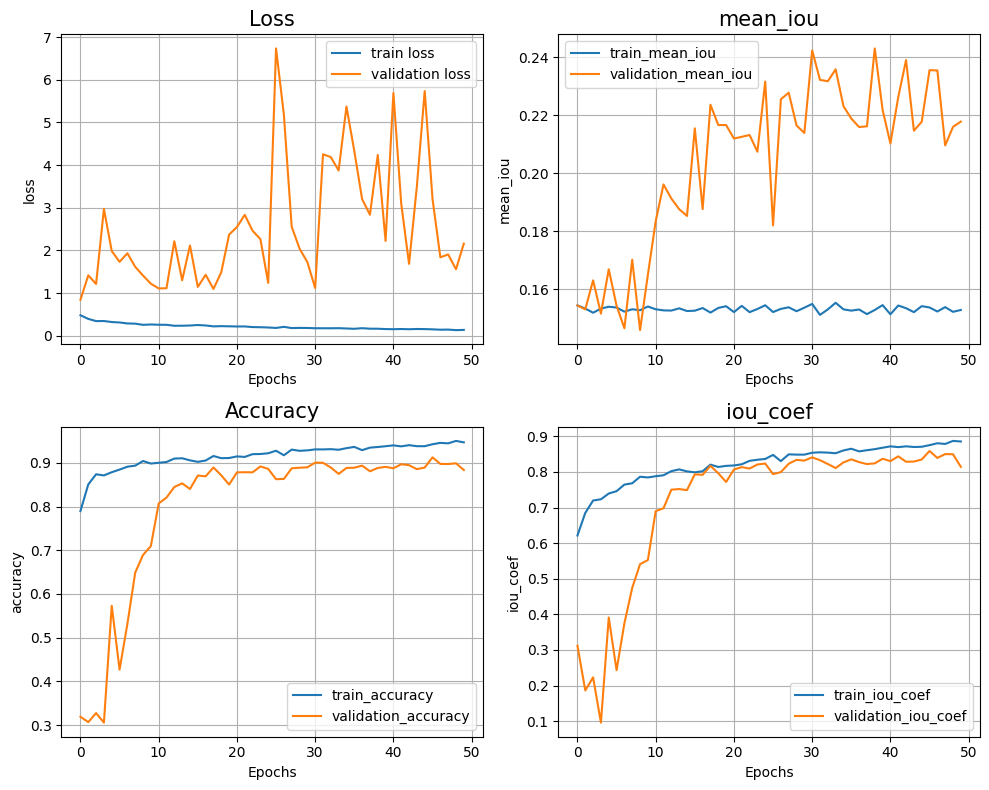

In [163]:
histori = taunet_model_history.history
plt.figure(figsize=(10,8))

plt.subplot(2,2,1)
train_loss = histori['loss']
val_loss = histori['val_loss']
plt.plot(train_loss, label='train loss')
plt.plot(val_loss, label='validation loss')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.title('Loss', fontsize = 15)
plt.legend()
plt.grid()

plt.subplot(2,2,2)
train_dice = histori['mean_iou']
val_dice = histori['val_mean_iou']
plt.plot(train_dice, label= 'train_mean_iou')
plt.plot(val_dice, label= 'validation_mean_iou')
plt.xlabel('Epochs')
plt.ylabel('mean_iou')
plt.title('mean_iou', fontsize = 15)
plt.legend()
plt.grid()


plt.subplot(2,2,3)
train_acc = histori['binary_accuracy']
val_acc = histori['val_binary_accuracy']
plt.plot(train_acc, label= 'train_accuracy')
plt.plot(val_acc, label= 'validation_accuracy')
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.legend()
plt.title('Accuracy', fontsize = 15)
plt.grid()

plt.subplot(2,2,4)
train_acc = histori['iou_coef']
val_acc = histori['val_iou_coef']
plt.plot(train_acc, label= 'train_iou_coef')
plt.plot(val_acc, label= 'validation_iou_coef')
plt.xlabel('Epochs')
plt.ylabel('iou_coef')
plt.title('iou_coef', fontsize = 15)
plt.grid()

plt.tight_layout()
plt.legend()
plt.show()

In [164]:
results = taunet_model.evaluate(test_gen, 
                         steps=len(test_df) / BATCH_SIZE)

print(f"Test loss: {results[0]:0.2f}")
print(f"Test acc: {results[1]*100:0.2f}%")
print(f"Test mean IOU: {results[2]:0.2f}")
print(f"Test IOU coef: {results[3]:0.2f}")

3/3 [==============================] - 0s 143ms/step - loss: 0.6585 - binary_accuracy: 0.8766 - mean_iou: 0.2252 - iou_coef: 0.7686
Test loss: 0.66
Test acc: 87.66%
Test mean IOU: 0.23
Test IOU coef: 0.77


1/1 [==============================] - 0s 26ms/step


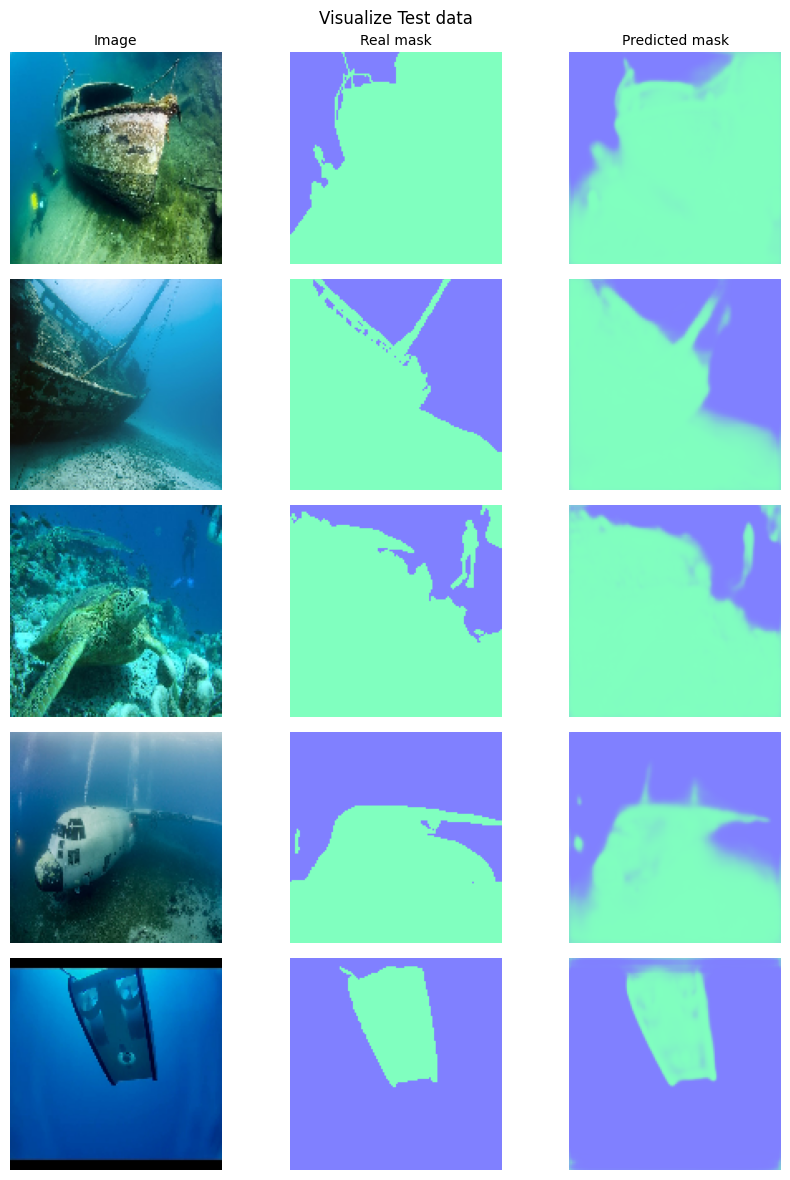

In [189]:
for img, mask in test_gen:
    break
pred = taunet_model.predict(img)

fig, ax = plt.subplots(nrows=5, ncols=3, figsize=(9,12))
plt.suptitle('Visualize Test data', fontsize = 12)
ax = ax.ravel()

for k, i in zip(range(0, 15, 3), range(0, 5)):
    
    ax[k].imshow(img[i])
    ax[k].axis('off')

    ax[k+1].imshow(mask[i], alpha = 0.5, cmap = 'winter')
    ax[k+1].axis('off')
    
    ax[k+2].imshow(pred[i], alpha = 0.5, cmap = 'winter')
    ax[k+2].axis('off')
    
ax[0].set_title('Image', fontsize = 10)
ax[1].set_title('Real mask', fontsize = 10)
ax[2].set_title('Predicted mask', fontsize = 10)
plt.tight_layout()
plt.show()

# multi channel mask

**Augmetation**
===

In [25]:
def train_generator(data_frame, batch_size, target_size=(128,128), train = True, seed=1):
    
    if train:
        
        image_datagen = ImageDataGenerator(rotation_range=0.2, width_shift_range=0.05, height_shift_range=0.05, shear_range=0.05,
                                            zoom_range=0.05, horizontal_flip=True, fill_mode='nearest')

        mask_datagen = ImageDataGenerator(rotation_range=0.2, width_shift_range=0.05, height_shift_range=0.05, shear_range=0.05,
                                          zoom_range=0.05, horizontal_flip=True, fill_mode='nearest')
        
    else:
        image_datagen = ImageDataGenerator()

        mask_datagen = ImageDataGenerator()
                                       
    image_generator = image_datagen.flow_from_dataframe(
        data_frame,
        x_col = "images",
        color_mode = 'rgb',
        class_mode = None,
        target_size = target_size,
        batch_size = batch_size,
        seed = seed)

    mask_generator = mask_datagen.flow_from_dataframe(
        data_frame,
        x_col = "masks",
        color_mode = 'rgb',
        class_mode = None,
        target_size = target_size,
        batch_size = batch_size,
        seed = seed)
                                       
                                                                  
    train_gen = zip(image_generator, mask_generator)
    
    for (img, mask) in train_gen:
        img = img/255.
        mask = mask/255.
#         mask[mask>=0.1]= 1,
#         mask[mask<0.1]= 0,

        yield (img, mask)

In [19]:
BATCH_SIZE = 4
im_height = 320
im_width = 240

train_gen = train_generator(train_df, BATCH_SIZE, target_size=(im_height,im_width), train = True, seed=1)
valid_gen = train_generator(val_df, BATCH_SIZE, target_size=(im_height,im_width), train = False, seed=1)
test_gen = train_generator(test_df, BATCH_SIZE, target_size=(im_height,im_width), train = False, seed=1)

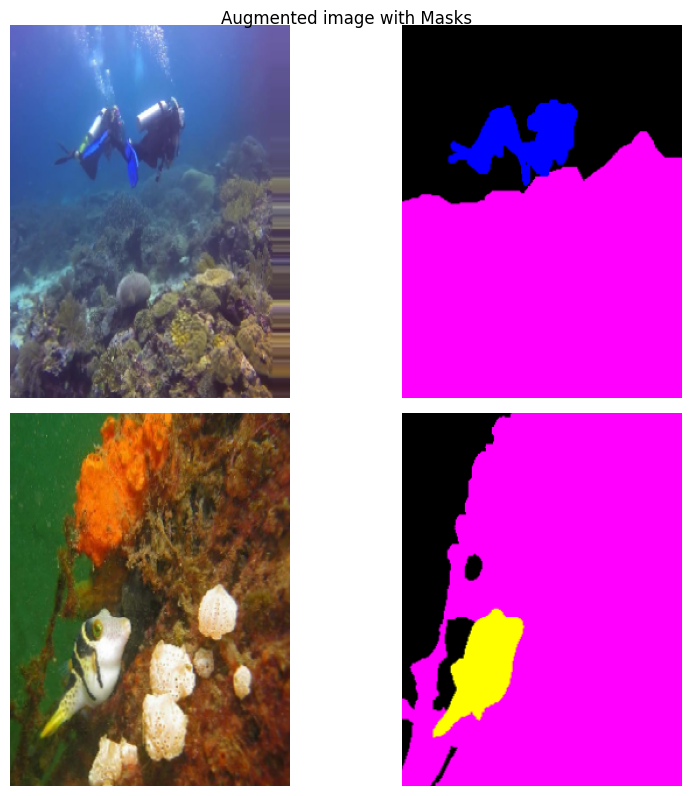

In [21]:
for (img, mask) in train_gen:
    break
    
idx = [0, 2]

plt.figure(figsize=(8, 16))
plt.suptitle('Augmented image with Masks')
for i in idx:
    
    plt.subplot(4, 2, i+1)
    image = (img[i]*255).astype(np.uint8)
    plt.imshow(image)
    plt.axis('off')
    
    plt.subplot(4, 2, i+2)
    plt.imshow(mask[i], cmap='gray')
    plt.axis('off')

plt.tight_layout()
plt.show()

# UNet multi channel mask

In [24]:
def UNet(input_size=(im_height,im_width,3)):
    
    inputs = Input(input_size)
    
    conv1, pool1, drp1 = conv_down(inputs, 64)
    conv2, pool2, drp2 = conv_down(pool1, 128)    
    conv3, pool3, drp3 = conv_down(pool2, 256)    
    conv4, pool4, drp4 = conv_down(pool3, 512)    
    _, _ , drp5 = conv_down(pool4, 1024)   
    
    drp6 = conv_up(drp5, drp4, 512, 512)
    drp7 = conv_up(drp6, drp3, 256, 256)    
    drp8 = conv_up(drp7, drp2, 128, 64)    
    drp9 = conv_up(drp8, drp1, 64, 64)
    
    out = Conv2D(3, (3, 3), padding='same', activation='relu', kernel_initializer='he_normal')(drp9)
    out = Conv2D(3, (1, 1), activation='sigmoid')(out)
    
    return Model(inputs=[inputs], outputs=[out])

**Train**
===

In [27]:
BATCH_SIZE = 40
im_height = 128
im_width = 128

train_gen = train_generator(train_df, BATCH_SIZE, target_size=(im_height,im_width), train = True, seed=1)
valid_gen = train_generator(val_df, BATCH_SIZE, target_size=(im_height,im_width), train = False, seed=1)
test_gen = train_generator(test_df, BATCH_SIZE, target_size=(im_height,im_width), train = False, seed=1)

In [29]:
EPOCHS = 50
num_class = 3
BATCH_SIZE = 40
im_height = 128
im_width = 128

mean_iou = keras.metrics.MeanIoU(num_classes=num_class, name="mean_iou")
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0005)

unet_model = UNet(input_size=(im_height, im_width, 3))
unet_model.compile(optimizer=optimizer, loss= 'binary_crossentropy', metrics=["binary_accuracy", mean_iou, iou_coef])

unet_model_history = unet_model.fit(train_gen,
                    steps_per_epoch = len(train_df) / BATCH_SIZE, 
                    epochs=EPOCHS, 
                    validation_data = valid_gen,
                    validation_steps = len(val_df) / BATCH_SIZE)
                    #callbacks = callbacks)

Found 1373 validated image filenames.
Found 1373 validated image filenames.
Epoch 1/50


2024-06-28 11:19:45.932214: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


35/34 [==============================] - ETA: 0s - loss: 0.6597 - binary_accuracy: 0.6293 - mean_iou: 0.2650 - iou_coef: 0.3660Found 152 validated image filenames.
Found 152 validated image filenames.
34/34 [==============================] - 45s 638ms/step - loss: 0.6597 - binary_accuracy: 0.6293 - mean_iou: 0.2650 - iou_coef: 0.3660 - val_loss: 8.1311 - val_binary_accuracy: 0.5996 - val_mean_iou: 0.2586 - val_iou_coef: 0.2425
Epoch 2/50
34/34 [==============================] - 16s 477ms/step - loss: 0.6037 - binary_accuracy: 0.6807 - mean_iou: 0.2645 - iou_coef: 0.3955 - val_loss: 1.9430 - val_binary_accuracy: 0.5161 - val_mean_iou: 0.2625 - val_iou_coef: 0.0596
Epoch 3/50
34/34 [==============================] - 16s 475ms/step - loss: 0.6011 - binary_accuracy: 0.6766 - mean_iou: 0.2645 - iou_coef: 0.3977 - val_loss: 4.7326 - val_binary_accuracy: 0.5393 - val_mean_iou: 0.2601 - val_iou_coef: 0.0758
Epoch 4/50
34/34 [==============================] - 16s 472ms/step - loss: 0.6057 - bin

**Result**
===

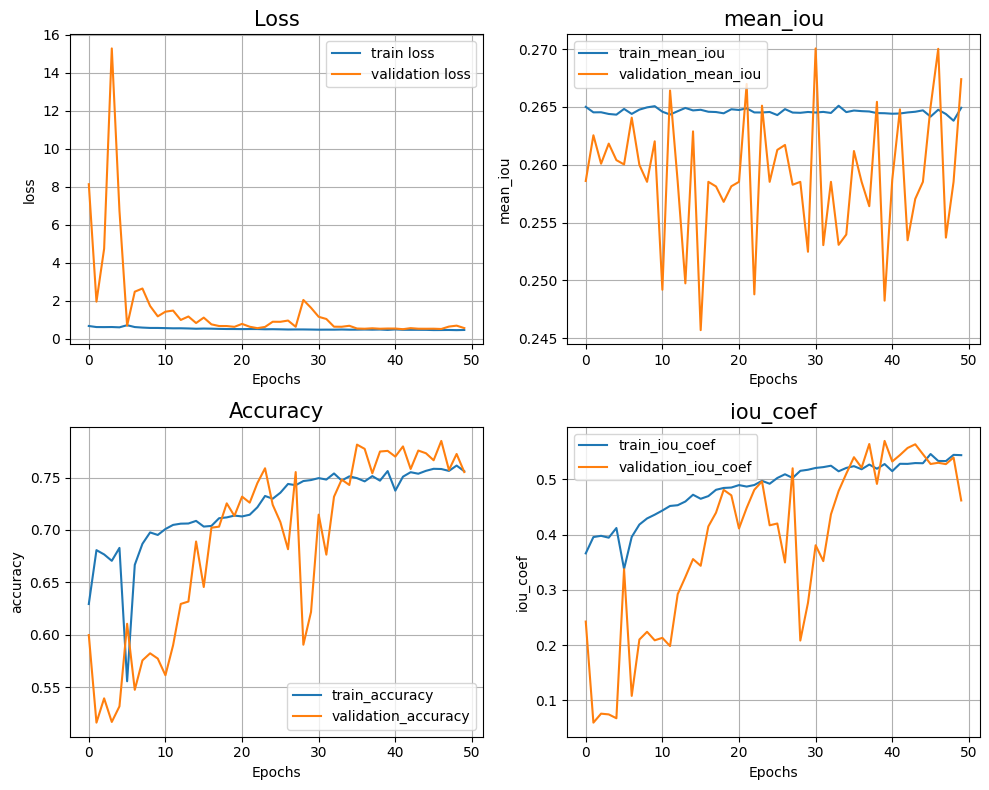

In [30]:
histori = unet_model_history.history
plt.figure(figsize=(10,8))

plt.subplot(2,2,1)
train_loss = histori['loss']
val_loss = histori['val_loss']
plt.plot(train_loss, label='train loss')
plt.plot(val_loss, label='validation loss')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.title('Loss', fontsize = 15)
plt.legend()
plt.grid()

plt.subplot(2,2,2)
train_dice = histori['mean_iou']
val_dice = histori['val_mean_iou']
plt.plot(train_dice, label= 'train_mean_iou')
plt.plot(val_dice, label= 'validation_mean_iou')
plt.xlabel('Epochs')
plt.ylabel('mean_iou')
plt.title('mean_iou', fontsize = 15)
plt.legend()
plt.grid()


plt.subplot(2,2,3)
train_acc = histori['binary_accuracy']
val_acc = histori['val_binary_accuracy']
plt.plot(train_acc, label= 'train_accuracy')
plt.plot(val_acc, label= 'validation_accuracy')
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.legend()
plt.title('Accuracy', fontsize = 15)
plt.grid()

plt.subplot(2,2,4)
train_acc = histori['iou_coef']
val_acc = histori['val_iou_coef']
plt.plot(train_acc, label= 'train_iou_coef')
plt.plot(val_acc, label= 'validation_iou_coef')
plt.xlabel('Epochs')
plt.ylabel('iou_coef')
plt.title('iou_coef', fontsize = 15)
plt.grid()

plt.tight_layout()
plt.legend()
plt.show()

In [31]:
results = unet_model.evaluate(test_gen, 
                         steps=len(test_df) / BATCH_SIZE)

print(f"Test loss: {results[0]:0.2f}")
print(f"Test acc: {results[1]*100:0.2f}%")
print(f"Test mean IOU: {results[2]:0.2f}")
print(f"Test IOU coef: {results[3]:0.2f}")

Found 110 validated image filenames.
Found 110 validated image filenames.
2/2 [==============================] - 2s 1s/step - loss: 0.5150 - binary_accuracy: 0.7370 - mean_iou: 0.2827 - iou_coef: 0.4510
Test loss: 0.51
Test acc: 73.70%
Test mean IOU: 0.28
Test IOU coef: 0.45


1/1 [==============================] - 0s 24ms/step


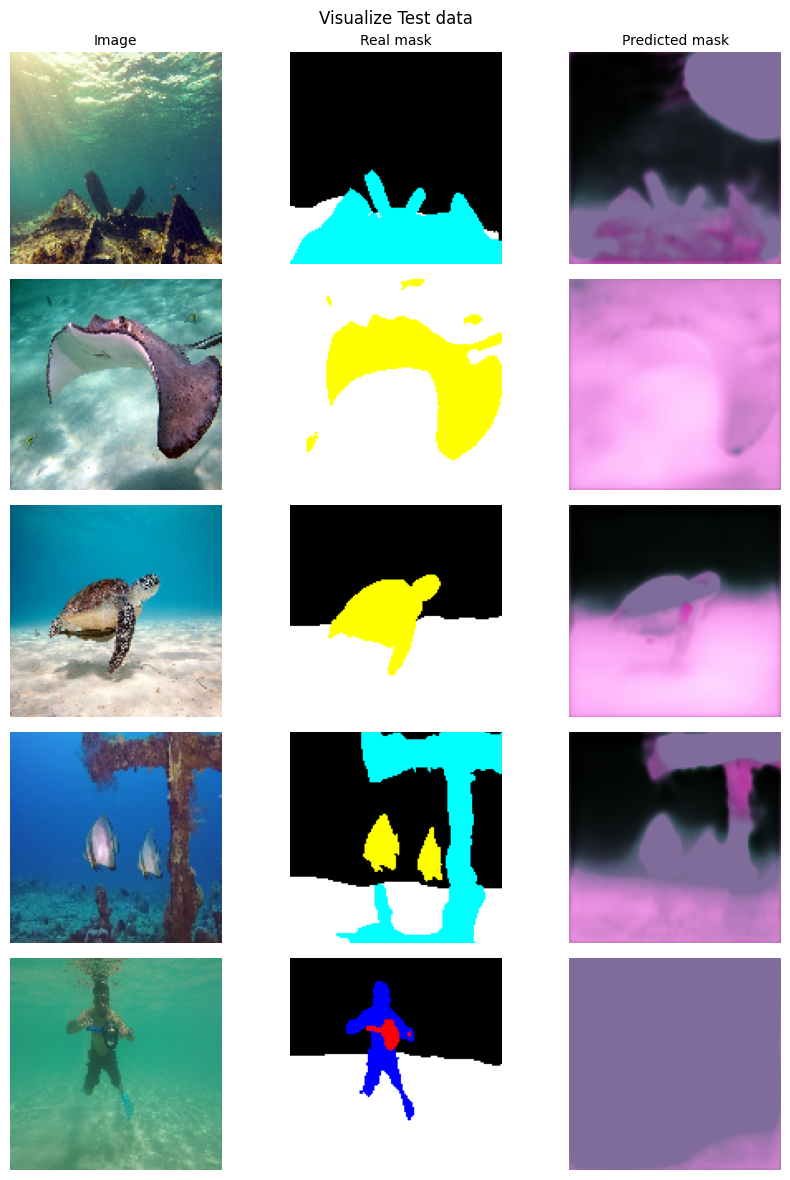

In [48]:
for img, mask in test_gen:
    break
pred = unet_model.predict(img)
# pred = np.where(pred[:,:,:,0:]>0.5, 1, 0)

fig, ax = plt.subplots(nrows=5, ncols=3, figsize=(9,12))
plt.suptitle('Visualize Test data', fontsize = 12)
ax = ax.ravel()

for k, i in zip(range(0, 15, 3), range(0, 5)):
    
    ax[k].imshow(img[i])
    ax[k].axis('off')

    ax[k+1].imshow(mask[i])
    ax[k+1].axis('off')
    
    ax[k+2].imshow(pred[i])
    ax[k+2].axis('off')
    
ax[0].set_title('Image', fontsize = 10)
ax[1].set_title('Real mask', fontsize = 10)
ax[2].set_title('Predicted mask', fontsize = 10)
plt.tight_layout()
plt.show()

# TA-UNet multi channel mask

In [108]:
def TA_UNet(input_size=(im_height,im_width,3)):
    
    inputs = Input(input_size)
    
    conv1, pool1, drp1 = conv_down(inputs, 64)
    conv2, pool2, drp2 = conv_down(pool1, 128, attention=True)    
    conv3, pool3, drp3 = conv_down(pool2, 256, attention=True)    
    conv4, pool4, drp4 = conv_down(pool3, 512, attention=True)    
    _, _ , drp5 = conv_down(pool4, 1024)   
    
    drp6 = conv_up(drp5, drp4, 512, 512)
    drp7 = conv_up(drp6, drp3, 256, 256)    
    drp8 = conv_up(drp7, drp2, 128, 64)    
    drp9 = conv_up(drp8, drp1, 64, 64)
    
    out = Conv2D(3, (3, 3), padding='same', activation='relu', kernel_initializer='he_normal')(drp9)
    out = Conv2D(3, (1, 1), activation='sigmoid')(out)
    
    return Model(inputs=[inputs], outputs=[out])

**Train**
===

In [109]:
BATCH_SIZE = 40
im_height = 128
im_width = 128

train_gen = train_generator(train_df, BATCH_SIZE, target_size=(im_height,im_width), train = True, seed=1)
valid_gen = train_generator(val_df, BATCH_SIZE, target_size=(im_height,im_width), train = False, seed=1)
test_gen = train_generator(test_df, BATCH_SIZE, target_size=(im_height,im_width), train = False, seed=1)

In [110]:
EPOCHS = 50
n_classes = 3
BATCH_SIZE = 40
im_height = 128
im_width = 128

mean_iou = keras.metrics.MeanIoU(num_classes=n_classes, name="mean_iou")
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0005)

taunet_model = TA_UNet(input_size=(im_height, im_width, 3))
taunet_model.compile(optimizer=optimizer, loss= 'binary_crossentropy', metrics=["binary_accuracy", mean_iou, iou_coef])

taunet_model_history = taunet_model.fit(train_gen,
                    steps_per_epoch = len(train_df) / BATCH_SIZE, 
                    epochs=EPOCHS, 
                    validation_data = valid_gen,
                    validation_steps = len(val_df) / BATCH_SIZE)
                    #callbacks = [reduce_lr])

Found 1373 validated image filenames.
Found 1373 validated image filenames.
Epoch 1/50


2024-06-28 08:38:34.106438: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_14/dropout_126/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


35/34 [==============================] - ETA: 0s - loss: 0.5868 - binary_accuracy: 0.7009 - mean_iou: 0.2650 - iou_coef: 0.4209Found 152 validated image filenames.
Found 152 validated image filenames.
34/34 [==============================] - 44s 525ms/step - loss: 0.5868 - binary_accuracy: 0.7009 - mean_iou: 0.2650 - iou_coef: 0.4209 - val_loss: 0.9175 - val_binary_accuracy: 0.6942 - val_mean_iou: 0.2586 - val_iou_coef: 0.4519
Epoch 2/50
34/34 [==============================] - 16s 469ms/step - loss: 0.5430 - binary_accuracy: 0.7242 - mean_iou: 0.2646 - iou_coef: 0.4534 - val_loss: 2.0753 - val_binary_accuracy: 0.5235 - val_mean_iou: 0.2625 - val_iou_coef: 0.1171
Epoch 3/50
34/34 [==============================] - 16s 481ms/step - loss: 0.5349 - binary_accuracy: 0.7281 - mean_iou: 0.2645 - iou_coef: 0.4590 - val_loss: 5.5396 - val_binary_accuracy: 0.5309 - val_mean_iou: 0.2601 - val_iou_coef: 0.0575
Epoch 4/50
34/34 [==============================] - 16s 476ms/step - loss: 0.5286 - bin

**Result**
===

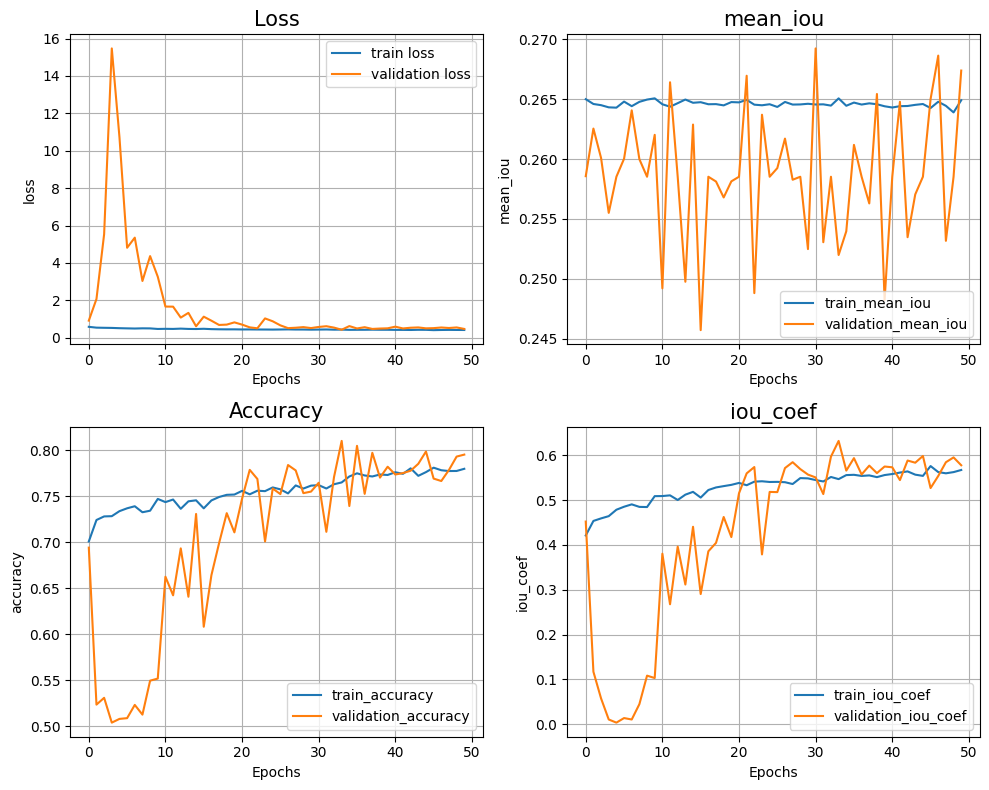

In [112]:
histori = taunet_model_history.history
plt.figure(figsize=(10,8))

plt.subplot(2,2,1)
train_loss = histori['loss']
val_loss = histori['val_loss']
plt.plot(train_loss, label='train loss')
plt.plot(val_loss, label='validation loss')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.title('Loss', fontsize = 15)
plt.legend()
plt.grid()

plt.subplot(2,2,2)
train_dice = histori['mean_iou']
val_dice = histori['val_mean_iou']
plt.plot(train_dice, label= 'train_mean_iou')
plt.plot(val_dice, label= 'validation_mean_iou')
plt.xlabel('Epochs')
plt.ylabel('mean_iou')
plt.title('mean_iou', fontsize = 15)
plt.legend()
plt.grid()


plt.subplot(2,2,3)
train_acc = histori['binary_accuracy']
val_acc = histori['val_binary_accuracy']
plt.plot(train_acc, label= 'train_accuracy')
plt.plot(val_acc, label= 'validation_accuracy')
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.legend()
plt.title('Accuracy', fontsize = 15)
plt.grid()

plt.subplot(2,2,4)
train_acc = histori['iou_coef']
val_acc = histori['val_iou_coef']
plt.plot(train_acc, label= 'train_iou_coef')
plt.plot(val_acc, label= 'validation_iou_coef')
plt.xlabel('Epochs')
plt.ylabel('iou_coef')
plt.title('iou_coef', fontsize = 15)
plt.grid()

plt.tight_layout()
plt.legend()
plt.show()

In [111]:
results = taunet_model.evaluate(test_gen, 
                         steps=len(test_df) / BATCH_SIZE)

print(f"Test loss: {results[0]:0.2f}")
print(f"Test acc: {results[1]*100:0.2f}%")
print(f"Test mean IOU: {results[2]:0.2f}")
print(f"Test IOU coef: {results[3]:0.2f}")

Found 110 validated image filenames.
Found 110 validated image filenames.
2/2 [==============================] - 3s 1s/step - loss: 0.4874 - binary_accuracy: 0.7874 - mean_iou: 0.2827 - iou_coef: 0.5356
Test loss: 0.49
Test acc: 78.74%
Test mean IOU: 0.28
Test IOU coef: 0.54


1/1 [==============================] - 0s 28ms/step


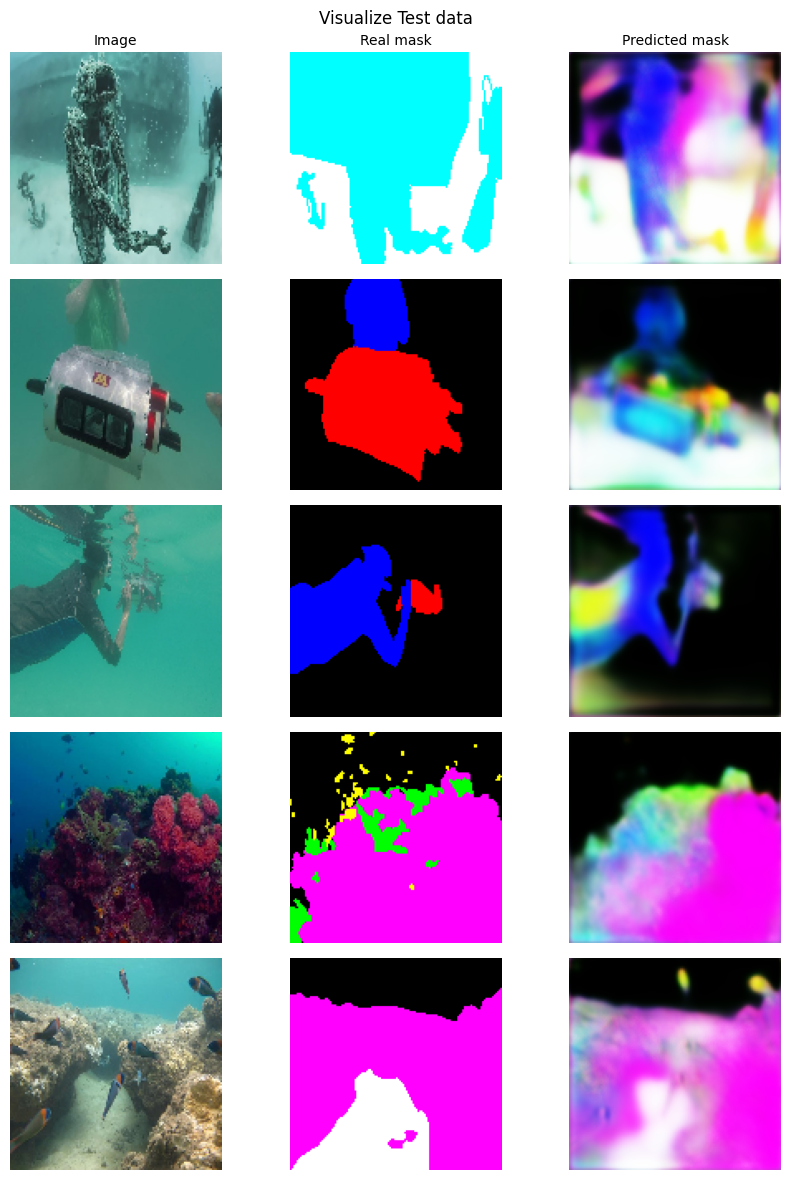

In [92]:
for img, mask in test_gen:
    break
pred = taunet_model.predict(img)
pred = np.where(pred[:,:,:,0:]>0.5, 1, 0)

fig, ax = plt.subplots(nrows=5, ncols=3, figsize=(9,12))
plt.suptitle('Visualize Test data', fontsize = 12)
ax = ax.ravel()

for k, i in zip(range(0, 15, 3), range(0, 5)):
    
    ax[k].imshow(img[i])
    ax[k].axis('off')

    ax[k+1].imshow(mask[i])
    ax[k+1].axis('off')
    
    ax[k+2].imshow(pred[i])
    ax[k+2].axis('off')
    
ax[0].set_title('Image', fontsize = 10)
ax[1].set_title('Real mask', fontsize = 10)
ax[2].set_title('Predicted mask', fontsize = 10)
plt.tight_layout()
plt.show()